# Predicting Football Match Outcome

In [120]:
# Importing all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef

In [2]:
df = pd.read_csv('E0.csv')
df.shape

(370, 106)

In [121]:
#No duplicates Found
df = df.loc[:,~df.columns.duplicated()]
df.shape

(370, 146)

In [4]:
df.drop_duplicates(ignore_index = True,inplace = True)
df.shape

(370, 106)

In [5]:
df.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,E0,13/08/2021,20:00,Brentford,Arsenal,2,0,H,1,0,...,1.62,0.50,1.75,2.05,1.81,2.13,2.05,2.17,1.80,2.09
1,E0,14/08/2021,12:30,Man United,Leeds,5,1,H,1,0,...,2.25,-1.00,2.05,1.75,2.17,1.77,2.19,1.93,2.10,1.79
2,E0,14/08/2021,15:00,Burnley,Brighton,1,2,A,1,0,...,1.62,0.25,1.79,2.15,1.81,2.14,1.82,2.19,1.79,2.12
3,E0,14/08/2021,15:00,Chelsea,Crystal Palace,3,0,H,2,0,...,1.94,-1.50,2.05,1.75,2.12,1.81,2.16,1.93,2.06,1.82
4,E0,14/08/2021,15:00,Everton,Southampton,3,1,H,0,1,...,1.67,-0.50,2.05,1.88,2.05,1.88,2.08,1.90,2.03,1.86


In [122]:
# First we check if we have any null values in our predicted columns as well as different results
# then we make into categorical as note suggests.
print(df['FTR'].isnull().sum())
print(df['FTR'].value_counts())
df['Final'] = np.where(df['FTR'] == 'A',0,1)
# df.drop('FTR',axis = 1,inplace = True)

0
H    156
A    126
D     88
Name: FTR, dtype: int64


In [8]:
df.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,Final
0,E0,13/08/2021,20:00,Brentford,Arsenal,2,0,H,1,0,...,0.50,1.75,2.05,1.81,2.13,2.05,2.17,1.80,2.09,1
1,E0,14/08/2021,12:30,Man United,Leeds,5,1,H,1,0,...,-1.00,2.05,1.75,2.17,1.77,2.19,1.93,2.10,1.79,1
2,E0,14/08/2021,15:00,Burnley,Brighton,1,2,A,1,0,...,0.25,1.79,2.15,1.81,2.14,1.82,2.19,1.79,2.12,0
3,E0,14/08/2021,15:00,Chelsea,Crystal Palace,3,0,H,2,0,...,-1.50,2.05,1.75,2.12,1.81,2.16,1.93,2.06,1.82,1
4,E0,14/08/2021,15:00,Everton,Southampton,3,1,H,0,1,...,-0.50,2.05,1.88,2.05,1.88,2.08,1.90,2.03,1.86,1


From the Below Code we can Clearly see that Teams which have their home end up into win or Draw While Teams having Away Grounds are not that good Performance
Machester and Liverpool have similar performance in both Away and Home ground

In [9]:
# lets check for Home Ground Advantage of the teams
home_ground_win = df.groupby(['HomeTeam']).agg({'Final':'mean'}).reset_index()
home_ground_win.columns

Index(['HomeTeam', 'Final'], dtype='object')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

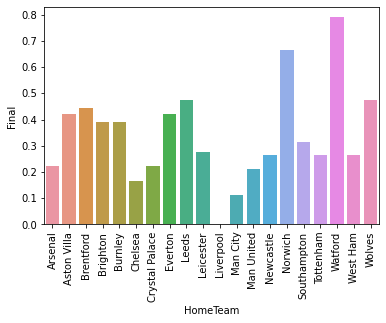

In [10]:
df['Final'] = np.where(df['FTR'] == 'A',1,0)
home_ground_win = df.groupby(['HomeTeam']).agg({'Final':'mean'}).reset_index()
sns.barplot(x='HomeTeam', y='Final', data= home_ground_win)
plt.xticks(rotation = 90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

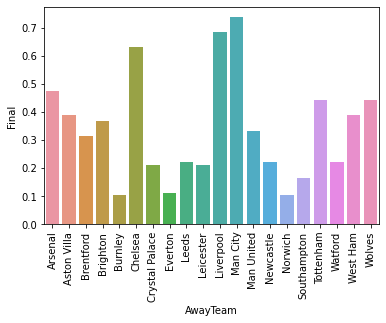

In [11]:
df['Final'] = np.where(df['FTR'] == 'A',1,0)
away_ground_win = df.groupby(['AwayTeam']).agg({'Final':'mean'}).reset_index()
sns.barplot(x='AwayTeam', y='Final', data= away_ground_win)
plt.xticks(rotation = 90)

We can Clearly see that having weekdays can impact the outcome of Away Teams winning or draw so we can keep this features as well however we can change this into categorical into weekdays or not

In [12]:
print(df['Date'].isnull().sum())
df['Dates'] = pd.to_datetime(df['Date'])
df['Dates'].dtype
df['WEEKDAY'] = np.where((df['Dates']).dt.dayofweek < 5,0,1)
df['WEEKDAY'].value_counts()

0


1    204
0    166
Name: WEEKDAY, dtype: int64

In [13]:
df_week_day = df[df['WEEKDAY'] == 1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

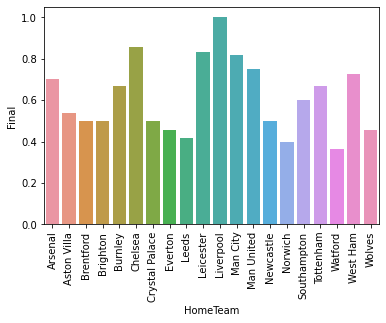

In [14]:
df_week_day['Final'] = np.where(df_week_day['FTR'] == 'A',0,1)
home_ground_win = df_week_day.groupby(['HomeTeam']).agg({'Final':'mean'}).reset_index()
sns.barplot(x='HomeTeam', y='Final', data= home_ground_win)
plt.xticks(rotation = 90)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

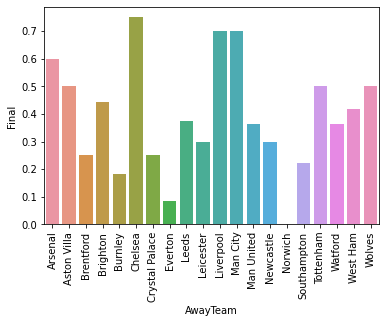

In [15]:
df_week_day['Final'] = np.where(df_week_day['FTR'] == 'A',1,0)
away_ground_win = df_week_day.groupby(['AwayTeam']).agg({'Final':'mean'}).reset_index()
sns.barplot(x='AwayTeam', y='Final', data= away_ground_win)
plt.xticks(rotation = 90)

Comparing the Result of Half Time and Full Time and get almost 60% matches have same win not enough information

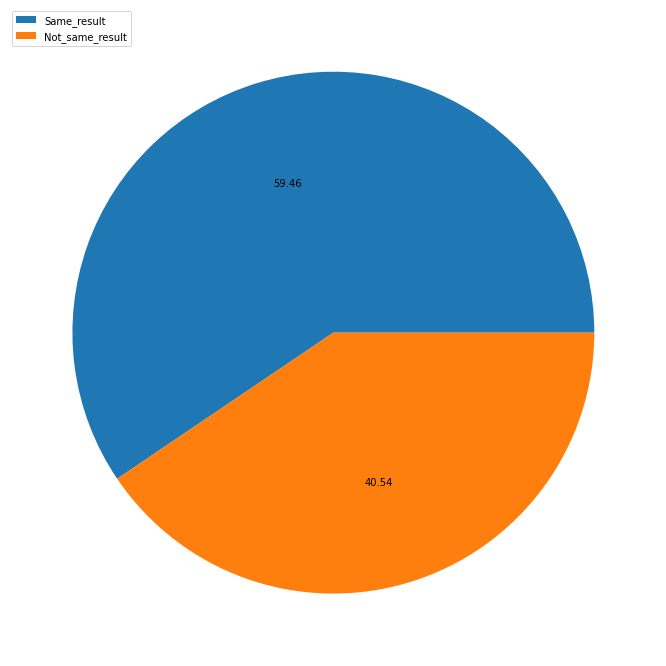

In [16]:
def autopct(pct): # only show the label when it's > 10%
    return ('%.2f' % pct) if pct > 10 else ''

df['same_half_and_full']  = np.where(df['FTR'] == df['HTR'],1,0)
my_labels = ['Same_result','Not_same_result']
ax = df['same_half_and_full'].value_counts().plot(kind='pie', figsize=(28,12),autopct=autopct,labels = None)
ax.axes.get_yaxis().set_visible(False)
plt.legend(loc= 2,labels=my_labels)

A fractional listing of 6/1 (six-to-one) odds would mean that you win 6 against every 1 you wager, in addition to receiving your dollar back (i.e., the amount you wagered)

Below we Tooks all the brokers Odd values and convert to percentage winning and as we only need to check Away wins or not

The value having higher odds of Winning put into one and did this for all brokers and take the maximum of the all brokers 

Then we check this with our final result and it clearly shows that our this feature is almost tells the correct answer

We plot all the ROC AUC Curves for all the merged columns and found and good AUC. This means we can say that This features are import.
We also did one analysis that most of the companies shows almost the same odds for the Teams.

We can Clearly see from AUC_ROC Curve all companies have almost same predictions and thier odds

97% of companies have same odds in term winning or draw of Home Teams 

We will drop all the columns which have odds values

In [18]:
# Getting the Probability of Winning according to B365
def convert_binary(x,y,z):
  probH = x
  probD = y
  probA = z
  h,d,a = (1/probH)*100,(1/probD)*100,(1/probA)*100
  total = h+d+a
  h,d,a = (h/total)*100,(d/total)*100,(a/total)*100
  max_h = max(h,d)
  if a > max_h:
    return 1
  else: return 0

In [19]:
df['B365Odds'] = df.apply (lambda row: convert_binary(row['B365H'],row['B365D'],row['B365A']), axis=1)

In [20]:
odd_str = ['B365','BW','IW','PS','VC','WH']
for i in odd_str:
  df[i+'Odds'] = df.apply (lambda row: convert_binary(row[i+'H'],row[i+'D'],row[i+'A']), axis=1)

In [21]:
cols_needed = [a+'Odds' for a in odd_str] + ['HomeTeam','AwayTeam','FTR']

In [22]:
df_odds = df[cols_needed]

In [23]:
df_odds.head()

,B365Odds,BWOdds,IWOdds,PSOdds,VCOdds,WHOdds,HomeTeam,AwayTeam,FTR
0,1,1,1,1,1,1,Brentford,Arsenal,H
1,0,0,0,0,0,0,Man United,Leeds,H
2,1,1,1,1,1,1,Burnley,Brighton,A
3,0,0,0,0,0,0,Chelsea,Crystal Palace,H
4,0,0,0,0,0,0,Everton,Southampton,H


In [24]:
from sklearn import metrics
def make_AUC_ROC(df_odds,feature):
  fpr, tpr, thresholds = metrics.roc_curve(np.where(df_odds['FTR']=='A',1,0), df_odds[feature])
  auc1 = metrics.auc(fpr,tpr)

  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()
  return plt.show()

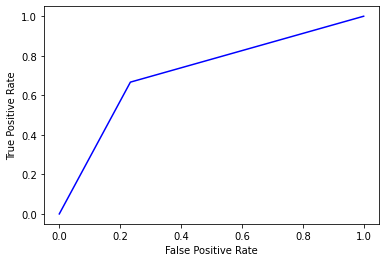

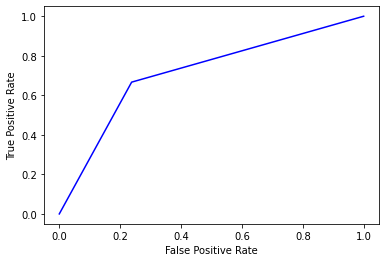

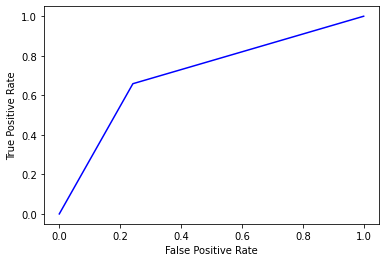

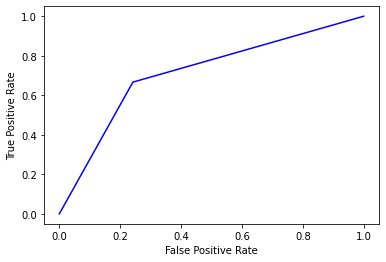

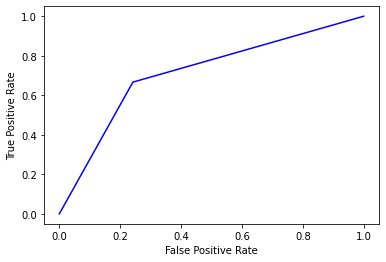

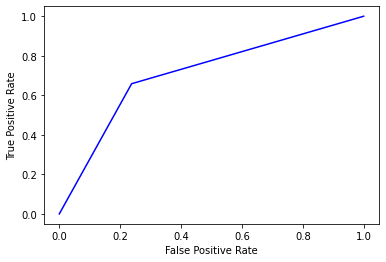

In [25]:
make_AUC_ROC(df_odds,'B365Odds')
make_AUC_ROC(df_odds,'BWOdds')
make_AUC_ROC(df_odds,'IWOdds')
make_AUC_ROC(df_odds,'PSOdds')
make_AUC_ROC(df_odds,'VCOdds')
make_AUC_ROC(df_odds,'WHOdds')


In [26]:
df_odds.columns

Index(['B365Odds', 'BWOdds', 'IWOdds', 'PSOdds', 'VCOdds', 'WHOdds',
       'HomeTeam', 'AwayTeam', 'FTR'],
      dtype='object')

In [27]:
def check_all_equal(a,b,c,d,e,f):
  ls = [a,b,c,d,e,f]
  flag = len(set(ls)) == 1
  if flag:
    return 1
  else:
    return 0
def max_preds(a,b,c,d,e,f):
  i = a+b+c+d+e
  if i>3:
    return 1
  else:
    return 0
df_odds['all_equal'] = df_odds.apply(lambda row: check_all_equal(row['B365Odds'],row['BWOdds'],row['IWOdds'],row['PSOdds'],row['VCOdds'],row['WHOdds']),axis = 1)
df_odds['max_odd'] = df_odds.apply(lambda row: max_preds(row['B365Odds'],row['BWOdds'],row['IWOdds'],row['PSOdds'],row['VCOdds'],row['WHOdds']),axis = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [28]:
df_odds['all_equal'].mean()

0.9783783783783784

In [29]:
df_odds['bool_FTR'] = np.where(df['FTR'] == 'A',1,0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [30]:
df_odds.groupby(['max_odd']).agg({'bool_FTR':'mean'})

,bool_FTR
max_odd,
0,0.183406
1,0.595745


We will do same analysis on Maximum and average odds also and comapre the results with final FTR

We get the same result as in our previous Analysis have on Odds of other companies

In [31]:
strs1 = ['Max','Avg']
for i in strs1:
  df[i+'Odds'] = df.apply (lambda row: convert_binary(row[i+'H'],row[i+'D'],row[i+'A']), axis=1)
cols_needed = [a+'Odds' for a in strs1] + ['HomeTeam','AwayTeam','FTR']
df_max_odds = df[cols_needed]

In [32]:
df_max_odds.head()

,MaxOdds,AvgOdds,HomeTeam,AwayTeam,FTR
0,1,1,Brentford,Arsenal,H
1,0,0,Man United,Leeds,H
2,1,1,Burnley,Brighton,A
3,0,0,Chelsea,Crystal Palace,H
4,0,0,Everton,Southampton,H


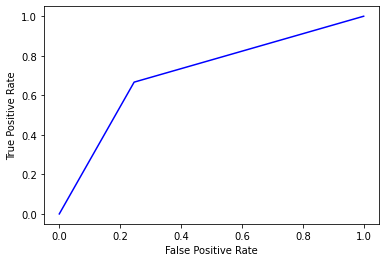

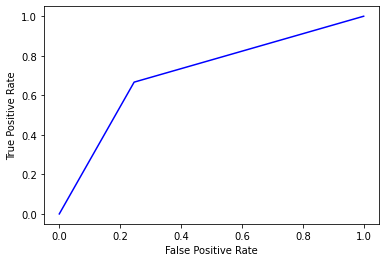

In [33]:
make_AUC_ROC(df_max_odds,'MaxOdds')
make_AUC_ROC(df_max_odds,'AvgOdds')

In [34]:
df['MaxOdds'] = df_max_odds['MaxOdds']
df['AvgOdds'] = df_max_odds['AvgOdds']

In [35]:
def max_preds(a,b,c,d,e,f,g,h):
  i = a+b+c+d+e
  if i>3:
    return 1
  else:
    return 0
df['max_preds_odds'] = df.apply(lambda row: max_preds(row['B365Odds'],row['BWOdds'],row['IWOdds'],row['PSOdds'],row['VCOdds'],row['WHOdds'],row['MaxOdds'],row['AvgOdds']),axis = 1)

Now we check for features with Under/Over 2.5 Goals.These feature looks like independent of winning team but we can check how good their predictions is 

https://www.squawka.com/en/bet/football-tips/over-2-5-goals/

In [36]:
# CHeck the odds for over 2.5 goals or not
def convert_binary(x,y):
  probO = x
  probU = y
  h,d = (1/probO)*100,(1/probU)*100
  total = h+d
  h,d = (h/total)*100,(d/total)*100
  if h>d:
    return 1
  else: return 0

In [37]:
df['Over2.5'] = df.apply(lambda row: convert_binary(row['B365>2.5'],row['B365<2.5']),axis = 1)

In [38]:
df_over = df[['Over2.5','HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG','HTAG', 'HTR']]

In [39]:
df_over['Total_goals'] = df.apply(lambda row: row['FTHG'] + row['FTAG'],axis = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [40]:
df_over['FTR'] = np.where(df['FTR'] == 'A',1,0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [41]:
df_over.head()

,Over2.5,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Total_goals
0,0,Brentford,Arsenal,2,0,0,1,0,H,2
1,1,Man United,Leeds,5,1,0,1,0,H,6
2,0,Burnley,Brighton,1,2,1,1,0,H,3
3,1,Chelsea,Crystal Palace,3,0,0,2,0,H,3
4,0,Everton,Southampton,3,1,0,0,1,A,4


In [42]:
def check(x,y):
  if x > 2 and y == 1:
    return 1
  if x <=2 and y == 0:
    return 1
  else:
    return 0
df['check_equal'] = df_over.apply(lambda row: check(row['Total_goals'],row['Over2.5']),axis = 1)

In [43]:
df['check_equal'].mean()

0.527027027027027

We can clearly see that Over 2.5 goals is not that good ratio to measure the number of goals it has 52% correct predictions on number of goals.
We wil do analysis over this feature but for now this will not show any result on predicting outcome.

We will frop this features

Check for HandiCap bettings 
I didnt get the exact terminologies of these handicap
https://www.unibet.co.uk/betting/guides/asian-handicap-explained-1.1008345

These are links from which I studied and understand

From the Handicap values we can clearly say that which team is stronger

From +ve,-ve values means the goals decided before match to keep the probabilty equal for both the team
I will convert it into binary and model will learn the things

# We will check the closing odds with earlier odds and check the change

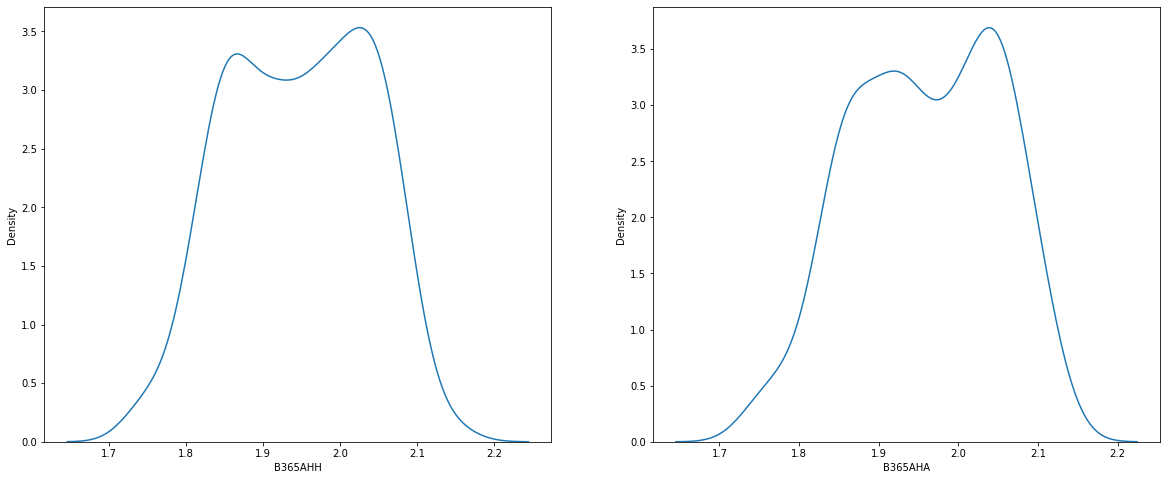

In [44]:
pfig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
sns.kdeplot(df['B365AHH'],ax = ax1)
sns.kdeplot(df['B365AHA'],ax = ax2)
plt.show()

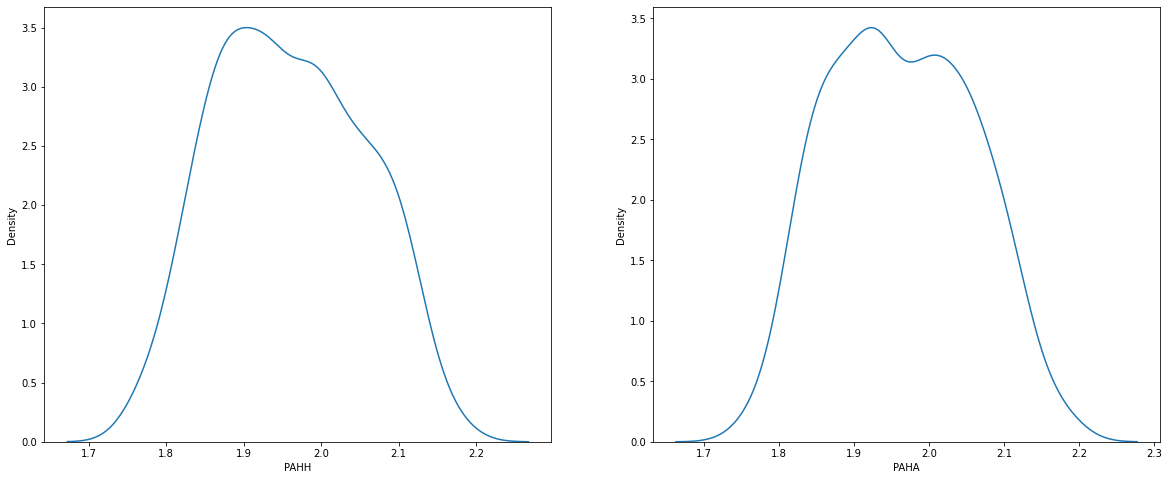

In [45]:
pfig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
sns.kdeplot(df['PAHH'],ax = ax1)
sns.kdeplot(df['PAHA'],ax = ax2)
plt.show()

There is not much difference in their distribution and their differences

All the Values of Asian Handicap is somewhat similar for the Home and Away odds so we can drop the feature as we get the information from AhH

Now we need to check the closing odds also and see if there is any difference in earlier odds and closing odds


In [46]:
# Getting the Probability of Winning according to B365
def convert_binary(x,y,z):
  probH = x
  probD = y
  probA = z
  h,d,a = (1/probH)*100,(1/probD)*100,(1/probA)*100
  total = h+d+a
  h,d,a = (h/total)*100,(d/total)*100,(a/total)*100
  max_h = max(h,d)
  if a > max_h:
    return 1
  else: return 0

In [47]:
df['B365Odds'] = df.apply(lambda row: convert_binary(row['B365H'],row['B365D'],row['B365A']),axis = 1)
df['B365COdds'] = df.apply(lambda row: convert_binary(row['B365CH'],row['B365CD'],row['B365CA']),axis = 1)

From this it is clearly state that 97% of time betting percentage winning not changes

In [48]:
np.where(df['B365Odds'] == df['B365COdds'],1,0).mean()

0.9675675675675676

In [49]:
# check for remain percentage as it is one the key factor to determine winner and might be anything that change at the end moment
df_closing = df.loc[df['B365Odds'] != df['B365COdds']]

In [50]:
len(df_closing)

12

In [51]:
df_closing= df_closing[['HomeTeam','AwayTeam','B365Odds','B365COdds','FTR']]

In [52]:
df_closing

,HomeTeam,AwayTeam,B365Odds,B365COdds,FTR
50,Chelsea,Man City,0,1,A
77,Everton,West Ham,0,1,A
87,Brentford,Leicester,0,1,A
108,Leeds,Leicester,1,0,D
112,Burnley,Crystal Palace,0,1,D
189,Chelsea,Liverpool,1,0,D
198,Aston Villa,Man United,1,0,D
206,Brentford,Wolves,1,0,A
225,Brentford,Crystal Palace,0,1,D
260,Newcastle,Brighton,1,0,H


From The above dataframe we can clearly see that almost all the closing and earlier odds are same but the one which differs will have realtion with output so we can keep this as well but we convert it into binary as earlier 

We not take max as we did earlier.
we can set to binary value of 1 if things matches to previous else 0


In [53]:
new_ls= ['B365C','BWC','IWC','PSC','WHC','VCC','MaxC','AvgC']

In [54]:
for i in new_ls:
  df[i+'Odds'] = df.apply (lambda row: convert_binary(row[i+'H'],row[i+'D'],row[i+'A']), axis=1)

In [55]:
new_ls= ['B365','BW','IW','PS','WH','VC','Max','Avg']
for i in new_ls:
  df['updated_'+i+'COdds'] = np.where(df[i+'COdds'] == df[i+'Odds'],1,0)

As we see earlier 2.5 goals not gives us information of winner so we drop these columns again

As for Asian handicap also

From below stats it is clear that Asian Handicap is good measure to check for winning and we will modify it and keep it 

In [56]:
df['AHh'].value_counts()

-0.25    54
 0.00    45
 0.25    40
-0.75    32
-0.50    31
-1.00    25
-1.25    21
 0.50    20
 0.75    19
 1.00    13
-1.50    12
-2.00    10
 1.50    10
 1.25    10
-1.75     8
-2.25     6
-2.50     5
 1.75     5
 2.00     3
 2.25     1
Name: AHh, dtype: int64

In [57]:
# For asian Handicap Games we need to check the goal difference('Goal supremecy') w.r.t home team goal because odd are in Homes.
df_asian = df[['HomeTeam','AwayTeam','FTHG','FTAG','AHh','AHCh']]

In [58]:
df_asian.head()

,HomeTeam,AwayTeam,FTHG,FTAG,AHh,AHCh
0,Brentford,Arsenal,2,0,0.50,0.50
1,Man United,Leeds,5,1,-1.00,-1.00
2,Burnley,Brighton,1,2,0.25,0.25
3,Chelsea,Crystal Palace,3,0,-1.50,-1.50
4,Everton,Southampton,3,1,-0.50,-0.50


In [59]:
df_asian['goal_diff'] = df.apply(lambda row: row['FTHG'] - row['FTAG'],axis = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [60]:
df_asian.head()

,HomeTeam,AwayTeam,FTHG,FTAG,AHh,AHCh,goal_diff
0,Brentford,Arsenal,2,0,0.50,0.50,2
1,Man United,Leeds,5,1,-1.00,-1.00,4
2,Burnley,Brighton,1,2,0.25,0.25,-1
3,Chelsea,Crystal Palace,3,0,-1.50,-1.50,3
4,Everton,Southampton,3,1,-0.50,-0.50,2


In [61]:
# Now we need to check for full,half,quater line Handicap
#For quarter values if they win game then only they get the whole amount with odds return if they end upto draw they get refund and if they loose they loose,
# for half they win or loose
def find_diff(x,y):
  if x >= y: #here we add equality too because we predict into the win,draw against loose
    return True
  else:
    False
def asian_handicap(homegoal,awaygoal,value,homeodds,awayodds):
  new_value = value*100
  if new_value%50 == 0:# for this values we clear that we win or losse and according to that we win money or loose
    new_home_goal = homegoal + value
    if find_diff(new_home_goal,awaygoal):
      return 0
    else:
      return 1
  else: # this includes odd to and consider our base money as 1 for find the risk that investors take(more risk more we get outcome)
    full_handicap = round(value)
    total_money = 0
    if value < 0:
      mid_value = value - 0.25
    else:
      mid_value = value + 0.25
    if homegoal - awaygoal > mid_value: # check for winning the match
      total_money = 0.5*homeodds
    if (homegoal - awaygoal) >= full_handicap:
      total_money = total_money + 0.5*homeodds
    else:
      total_money = total_money - 0.5*awayodds
    if total_money > 1:
      return 0
    else:
      return 1
    


In [62]:
#finding all the columns in df columns which have asian handicap
list_of_columns = df.columns
imp_col = [col for col in list_of_columns if col.find('AH') != -1]

In [63]:
imp_col

['AHh',
 'B365AHH',
 'B365AHA',
 'PAHH',
 'PAHA',
 'MaxAHH',
 'MaxAHA',
 'AvgAHH',
 'AvgAHA',
 'AHCh',
 'B365CAHH',
 'B365CAHA',
 'PCAHH',
 'PCAHA',
 'MaxCAHH',
 'MaxCAHA',
 'AvgCAHH',
 'AvgCAHA']

In [64]:
cols = ['B365','P','Max','Avg']
for i in cols:
  df[i+'asian'] = df.apply(lambda row:asian_handicap(row['FTHG'],row['FTAG'],row['AHh'],row[i+'AHH'],row[i+'AHA']),axis = 1)

In [65]:
df['bool_FTR'] = np.where(df['FTR'] == 'A',1,0)

In [66]:
#this means asian handicap is one of the good factor for predictions
np.where(df['B365asian'] == df['bool_FTR'],1,0).mean()

0.8324324324324325

In [70]:
cols = ['B365C','PC','MaxC','AvgC']
for i in cols:
  df[i+'asian'] = df.apply(lambda row:asian_handicap(row['FTHG'],row['FTAG'],row['AHCh'],row[i+'AHH'],row[i+'AHA']),axis = 1)

In [69]:
# we will take Average and AverageC asian and drop all columns

In [71]:
np.where(df['Avgasian'] == df['AvgCasian'],1,0).mean()

0.8675675675675676

Now we set to drop columns which is not used before match start and also which we modified doing analysis.

In [72]:
# we clearly saw from analysis max and avg odds behave same and profuce same results as company odds so we can put it into our whole max odds
keep_columns = ['WEEKDAY','max_preds_odds','HomeTeam','AwayTeam','FTR','AvgCasian','Avgasian'] #from above analysis
# columns whose string match with update
update_columns = [col for col in df.columns if 'update' in col]

In [73]:
new_columns = keep_columns + update_columns
new_columns

['WEEKDAY',
 'max_preds_odds',
 'HomeTeam',
 'AwayTeam',
 'FTR',
 'AvgCasian',
 'Avgasian',
 'updated_B365COdds',
 'updated_BWCOdds',
 'updated_IWCOdds',
 'updated_PSCOdds',
 'updated_WHCOdds',
 'updated_VCCOdds',
 'updated_MaxCOdds',
 'updated_AvgCOdds']

In [74]:
# we remove all odds except 'max_preds_odds'

In [75]:
df_new =df[new_columns]

In [76]:
df_new.shape

(370, 15)

In [77]:
# we need to give Teams a number 

In [78]:
team_names = list(df_new['HomeTeam'].value_counts().index)
team_names

['West Ham',
 'Leeds',
 'Wolves',
 'Everton',
 'Southampton',
 'Watford',
 'Newcastle',
 'Tottenham',
 'Man United',
 'Aston Villa',
 'Arsenal',
 'Brighton',
 'Man City',
 'Brentford',
 'Crystal Palace',
 'Norwich',
 'Leicester',
 'Chelsea',
 'Burnley',
 'Liverpool']

In [79]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(team_names)

LabelEncoder()

In [82]:
le.transform(team_names)

array([18,  8, 19,  7, 15, 17, 13, 16, 12,  1,  0,  3, 11,  2,  6, 14,  9,
        5,  4, 10])

In [83]:
df_new['transformHomeTeam'] = le.transform(df['HomeTeam'])
df_new['transformAwayTeam'] = le.transform(df['AwayTeam'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [84]:
df_new.drop(['HomeTeam','AwayTeam'],axis = 1,inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [85]:
df_new.columns

Index(['WEEKDAY', 'max_preds_odds', 'FTR', 'AvgCasian', 'Avgasian',
       'updated_B365COdds', 'updated_BWCOdds', 'updated_IWCOdds',
       'updated_PSCOdds', 'updated_WHCOdds', 'updated_VCCOdds',
       'updated_MaxCOdds', 'updated_AvgCOdds', 'transformHomeTeam',
       'transformAwayTeam'],
      dtype='object')

In [86]:
df_new['FTR'] = np.where(df_new['FTR'] == 'A',1,0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [87]:
df_new.head()

,WEEKDAY,max_preds_odds,FTR,AvgCasian,Avgasian,updated_B365COdds,updated_BWCOdds,updated_IWCOdds,updated_PSCOdds,updated_WHCOdds,updated_VCCOdds,updated_MaxCOdds,updated_AvgCOdds,transformHomeTeam,transformAwayTeam
0,0,1,0,0,0,1,1,1,1,1,1,1,1,2,0
1,1,0,0,0,0,1,1,1,1,1,1,1,1,12,8
2,1,1,1,1,1,1,1,1,1,1,1,1,1,4,3
3,1,0,0,0,0,1,1,1,1,1,1,1,1,5,6
4,1,0,0,0,0,1,1,1,1,1,1,1,1,7,15


In [88]:
df_new.shape

(370, 15)

In [89]:
X = df_new.drop('FTR',axis = 1)
Y = df_new['FTR']

In [102]:
Y.value_counts()

0    244
1    126
Name: FTR, dtype: int64

In [90]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size=0.2,random_state=0,stratify=Y)

In [91]:
len(x_train),len(x_test)

(296, 74)

In [110]:
def run_exps(x_train, y_train, x_test, y_test):
    
    dfs = []
    models = [
              ('LogReg', LogisticRegression()), 
              ('RF', RandomForestClassifier()),
              ('KNN', KNeighborsClassifier()),
              ('SVM', SVC()), 
              ('GNB', GaussianNB()),
              ('XGB', XGBClassifier())
            ]
    scoring = ['roc_auc']
    matrix = []
    # target_names = ['Away team Win', 'Loose']
    for name, model in models:
        Skfold = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=90210)
        cv_results = model_selection.cross_validate(model, x_train, y_train, cv=Skfold, scoring=scoring)
        clf = model.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        score_roc = roc_auc_score(y_test,y_pred)
        score_mcc = matthews_corrcoef(y_test, y_pred)
        matrix.append([name,score_roc,score_mcc])
    return matrix

In [ ]:
check_result = run_exps(x_train, y_train, x_test, y_test)

In [112]:
metrics = pd.DataFrame(check_result)

In [117]:
metrics.columns = [['Model','ROC_AUC','MCC']]

In [118]:
metrics

,Model,ROC_AUC,MCC
0,LogReg,0.778367,0.551581
1,RF,0.808571,0.611430
2,KNN,0.517551,0.038005
3,SVM,0.500000,0.000000
4,GNB,0.808163,0.597137
5,XGB,0.818776,0.637551
